In [38]:
import numpy as np
import os
import matplotlib.pyplot as plt
import yt
from multiprocess import Pool

# path of the simu we want to extract
RamsesDir, snap_zoom = '/scratch/Cral/rlenoble/04_zoom_cic/01_zoom/', 40
os.system('mkdir '+RamsesDir+'/plot/') # make folder to solve the plot
os.system('mkdir '+RamsesDir+'/plot/extract')

# path of the simu extracted
RamsesDir_extract = '/scratch/Cral/rlenoble/05_test_extract/'

mkdir: impossible de créer le répertoire « /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//plot/ »: Le fichier existe
mkdir: impossible de créer le répertoire « /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//plot/extract »: Le fichier existe


## 1) Choose the center of the extracted region

In [3]:
############
# Here select the max density of the central region

ds_zoom = yt.load(RamsesDir + 'output_%05d'%snap_zoom + '/info_%05d'%snap_zoom + '.txt')
region_center = ds_zoom.box([0.48, 0.48, 0.48], [0.52, 0.52, 0.52])

value, center = ds_zoom.find_max(('gas', 'number_density'))
center=center.value # in cu unit for later

print("Max nber density (cm**-3) : {:e}".format(value.to('cm**-3')))
print('Level max triggered  : ', np.max(region_center['index', 'grid_level'])+ds_zoom.min_level)
print('Level min triggered  : ', np.min(region_center['index', 'grid_level'])+ds_zoom.min_level)

yt : [INFO     ] 2024-05-06 13:36:25,967 Parameters: current_time              = 5.4635757857672935
yt : [INFO     ] 2024-05-06 13:36:25,969 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-05-06 13:36:25,970 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-06 13:36:25,971 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-05-06 13:36:25,972 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-05-06 13:36:25,972 Parameters: current_redshift          = 20.409194056958754
yt : [INFO     ] 2024-05-06 13:36:25,973 Parameters: omega_lambda              = 0.68419998884201
yt : [INFO     ] 2024-05-06 13:36:25,974 Parameters: omega_matter              = 0.31580001115799
yt : [INFO     ] 2024-05-06 13:36:25,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-05-06 13:36:25,975 Parameters: hubble_constant           = 0.6731999969482421
yt : [INFO     ] 2024-05-06 13:37:25,830 Adding particle_

Max nber density (cm**-3) : 4.047692e+08 cm**(-3)
Level max triggered  :  26.0 dimensionless
Level min triggered  :  9.0 dimensionless


## 2) Check the data extracted and how the zooms are computed

- `levelmax` : the max level from the zoom simulation extracted
    - `levelmax_HR_1` : first zoom
    - `levelmax_HR_2` : 2nd zoom

Here we do 2 grid, the second one doing half of the first one with the same resolution -> gain one level in the center. 
I'm not sure it can be tuned, as RAMSES want to increase the level 1 by one. So deviding the boxlen by two while keeping the same resolution enable to achieve this.

eps :  3.0517578125e-05
New box len (pc)     :  2.1174132910642536 pc
Small box len (1) (pc)   :  1.0587066455321268 pc
Small box len (2) (pc)   :  0.5293533227660634 pc


yt : [INFO     ] 2024-05-06 14:37:56,171 Parameters: current_time              = 5.4635757857672935
yt : [INFO     ] 2024-05-06 14:37:56,172 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-05-06 14:37:56,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-06 14:37:56,174 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-05-06 14:37:56,175 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-05-06 14:37:56,176 Parameters: current_redshift          = 20.409194056958754
yt : [INFO     ] 2024-05-06 14:37:56,178 Parameters: omega_lambda              = 0.68419998884201
yt : [INFO     ] 2024-05-06 14:37:56,178 Parameters: omega_matter              = 0.31580001115799
yt : [INFO     ] 2024-05-06 14:37:56,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-05-06 14:37:56,180 Parameters: hubble_constant           = 0.6731999969482421
yt : [INFO     ] 2024-05-06 14:37:56,683 xlim = 0.501568 

Mass cropped :  1798.0816478950846 Msun
Bulk velocity cropped :  [-119100.58669832 -402715.32315805  309102.22755197] cm/s
Level max triggered  :  26.0 dimensionless
Nuber of cells at max level   :  3576
Nuber of cells at max level -1:  25561
Level min triggered  :  18.0 dimensionless


yt : [INFO     ] 2024-05-06 14:37:56,685 ylim = 0.499264 0.499294
yt : [INFO     ] 2024-05-06 14:37:56,688 xlim = 0.501568 0.501598
yt : [INFO     ] 2024-05-06 14:37:56,689 ylim = 0.499264 0.499294
yt : [INFO     ] 2024-05-06 14:37:56,691 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2024-05-06 14:37:56,789 Making a fixed resolution buffer of (('index', 'grid_level')) 800 by 800
yt : [INFO     ] 2024-05-06 14:37:56,846 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



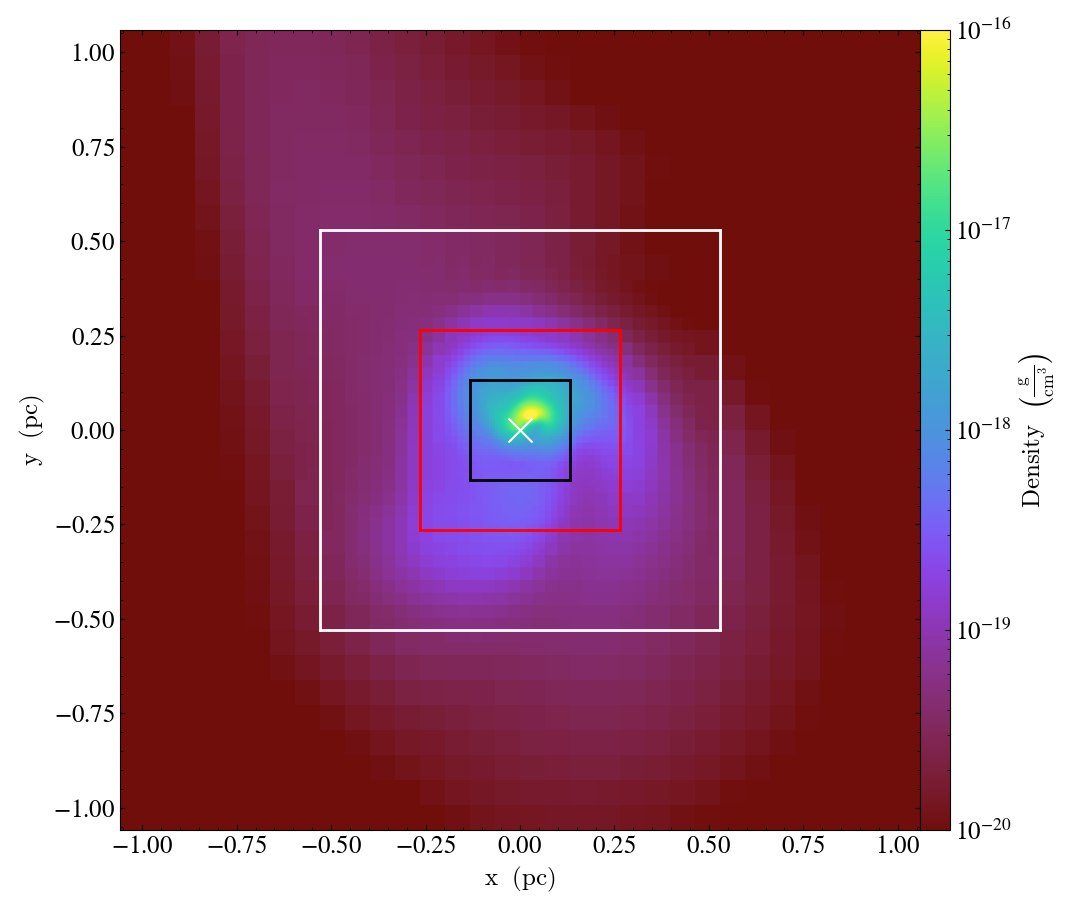
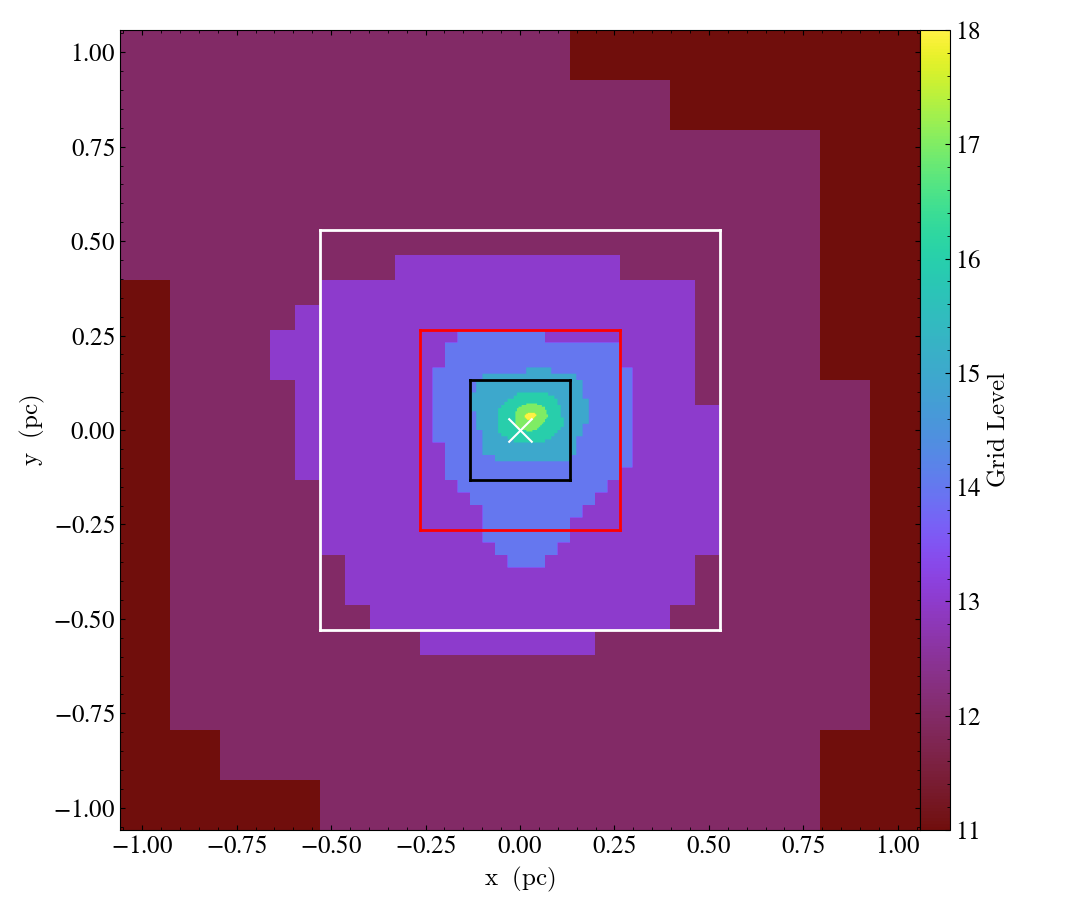
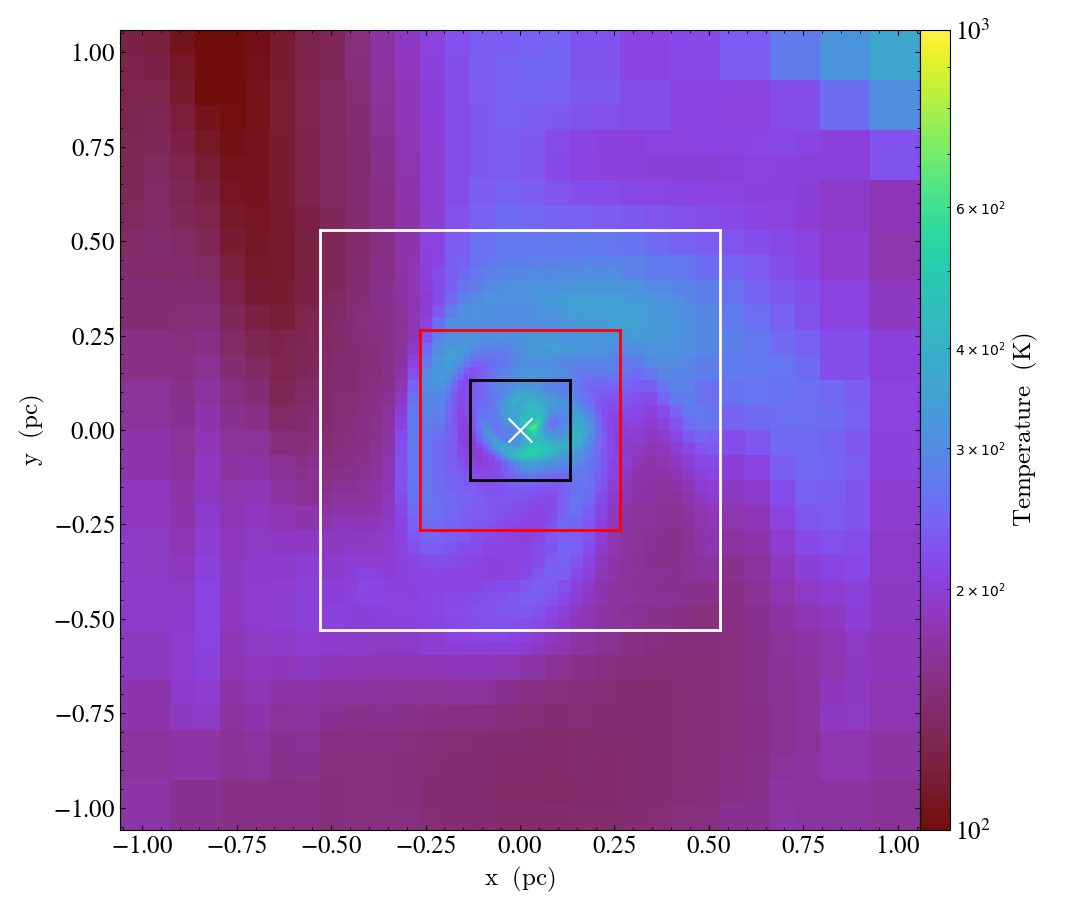

yt : [INFO     ] 2024-05-06 14:37:58,784 Saving plot /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//plot/extract/info_00040_Slice_z_density.png
yt : [INFO     ] 2024-05-06 14:37:59,009 Saving plot /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//plot/extract/info_00040_Slice_z_grid_level.png
yt : [INFO     ] 2024-05-06 14:37:59,199 Saving plot /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//plot/extract/info_00040_Slice_z_temperature.png
yt : [INFO     ] 2024-05-06 14:37:59,517 xlim = 0.501568 0.501598
yt : [INFO     ] 2024-05-06 14:37:59,518 ylim = 0.499264 0.499294
yt : [INFO     ] 2024-05-06 14:37:59,522 xlim = 0.501568 0.501598
yt : [INFO     ] 2024-05-06 14:37:59,522 ylim = 0.499264 0.499294
yt : [INFO     ] 2024-05-06 14:37:59,524 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2024-05-06 14:37:59,602 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800
yt : [INFO     ] 2024-05-06 14:37:59,857 Making a fixed resolution buffer of (('gas'

['/scratch/Cral/rlenoble/04_zoom_cic/01_zoom//plot/extract/info_00040_zoom_Slice_z_density.png',
 '/scratch/Cral/rlenoble/04_zoom_cic/01_zoom//plot/extract/info_00040_zoom_Slice_z_temperature.png']

In [39]:
# levelmax of the zoom simu and of each extracted simu
levelmax, final_res = 20, 2**5
levelmax_HR_1, final_res_HR_1 = 21, 2**5
levelmax_HR_2, final_res_HR_2 = 22, 2**5
levelmax_HR_3, final_res_HR_3 = 23, 2**5

eps = final_res*0.5**(levelmax)
eps_HR_1 = final_res_HR_1*0.5**(levelmax_HR_1)
eps_HR_2 = final_res_HR_2*0.5**(levelmax_HR_2)
eps_HR_3 = final_res_HR_3*0.5**(levelmax_HR_3)

# Important : center the box so that it corresponds to the cells
center[0] = round(center[0]*2**levelmax) / 2**levelmax
center[1] = round(center[1]*2**levelmax) / 2**levelmax
center[2] = round(center[2]*2**levelmax) / 2**levelmax

print('eps : ', eps)
print('New box len (pc)     : ', eps*ds_zoom.domain_width[0].to('pc'))
print('Small box len (1) (pc)   : ', eps_HR_1*ds_zoom.domain_width[0].to('pc'))
print('Small box len (2) (pc)   : ', eps_HR_2*ds_zoom.domain_width[0].to('pc'))

# extract regions
xmin, xmax = center[0] - eps / 2., center[0] + eps / 2.
ymin, ymax = center[1] - eps / 2., center[1] + eps / 2.
zmin, zmax = center[2] - eps / 2., center[2] + eps / 2.

xmin_HR_1, xmax_HR_1 = center[0] - eps_HR_1 / 2., center[0] + eps_HR_1 / 2.
ymin_HR_1, ymax_HR_1 = center[1] - eps_HR_1 / 2., center[1] + eps_HR_1 / 2.
zmin_HR_1, zmax_HR_1 = center[2] - eps_HR_1 / 2., center[2] + eps_HR_1 / 2.

xmin_HR_2, xmax_HR_2 = center[0] - eps_HR_2 / 2., center[0] + eps_HR_2 / 2.
ymin_HR_2, ymax_HR_2 = center[1] - eps_HR_2 / 2., center[1] + eps_HR_2 / 2.
zmin_HR_2, zmax_HR_2 = center[2] - eps_HR_2 / 2., center[2] + eps_HR_2 / 2.

xmin_HR_3, xmax_HR_3 = center[0] - eps_HR_3 / 2., center[0] + eps_HR_3 / 2.
ymin_HR_3, ymax_HR_3 = center[1] - eps_HR_3 / 2., center[1] + eps_HR_3 / 2.
zmin_HR_3, zmax_HR_3 = center[2] - eps_HR_3 / 2., center[2] + eps_HR_3 / 2.

ds_cropped = yt.load(RamsesDir + 'output_%05d'%snap_zoom + '/info_%05d'%snap_zoom + '.txt', bbox=([xmin, ymin, zmin], [xmax, ymax, zmax]))
cropped_region = ds_zoom.box([xmin, ymin, zmin], [xmax, ymax, zmax])

width_cropped = eps*ds_zoom.domain_width[0].to('pc')
mass_cropped = np.sum(cropped_region[('gas', 'mass')].to('Msun'))
bulk_vel_cropped = cropped_region.quantities.bulk_velocity()
print('Mass cropped : ', mass_cropped)
print('Bulk velocity cropped : ', bulk_vel_cropped)
print('Level max triggered  : ', np.max(cropped_region['index', 'grid_level'])+ds_zoom.min_level)
print('Nuber of cells at max level   : ', np.sum(cropped_region['index', 'grid_level']==np.max(cropped_region['index', 'grid_level'])))
print('Nuber of cells at max level -1: ', np.sum(cropped_region['index', 'grid_level']==np.max(cropped_region['index', 'grid_level'])-1))
print('Level min triggered  : ', np.min(cropped_region['index', 'grid_level'])+ds_zoom.min_level)



# Now we plot the central region with the rectangular to see what is extracted
plot = yt.SlicePlot(ds_zoom, 'z', 
                         [('gas', 'density'), ('gas', 'temperature'), ('index', 'grid_level')],
                   center = center, 
                   width=eps*ds_zoom.domain_width[0].to('pc'),
                   data_source=cropped_region,
                   )
plot.annotate_line([xmin_HR_1, ymin_HR_1, zmin_HR_1], [xmax_HR_1, ymin_HR_1, zmin_HR_1], coord_system="data")
plot.annotate_line([xmax_HR_1, ymin_HR_1, zmin_HR_1], [xmax_HR_1, ymax_HR_1, zmin_HR_1], coord_system="data")
plot.annotate_line([xmax_HR_1, ymax_HR_1, zmin_HR_1], [xmin_HR_1, ymax_HR_1, zmin_HR_1], coord_system="data")
plot.annotate_line([xmin_HR_1, ymax_HR_1, zmin_HR_1], [xmin_HR_1, ymin_HR_1, zmin_HR_1], coord_system="data")

plot.annotate_marker(center, coord_system="data", s=300)
plot.annotate_line([xmin_HR_2, ymin_HR_2, zmin_HR_2], [xmax_HR_2, ymin_HR_2, zmin_HR_2], coord_system="data", color='r')
plot.annotate_line([xmax_HR_2, ymin_HR_2, zmin_HR_2], [xmax_HR_2, ymax_HR_2, zmin_HR_2], coord_system="data", color='r')
plot.annotate_line([xmax_HR_2, ymax_HR_2, zmin_HR_2], [xmin_HR_2, ymax_HR_2, zmin_HR_2], coord_system="data", color='r')
plot.annotate_line([xmin_HR_2, ymax_HR_2, zmin_HR_2], [xmin_HR_2, ymin_HR_2, zmin_HR_2], coord_system="data", color='r')

plot.annotate_line([xmin_HR_3, ymin_HR_3, zmin_HR_3], [xmax_HR_3, ymin_HR_3, zmin_HR_3], coord_system="data", color='k')
plot.annotate_line([xmax_HR_3, ymin_HR_3, zmin_HR_3], [xmax_HR_3, ymax_HR_3, zmin_HR_3], coord_system="data", color='k')
plot.annotate_line([xmax_HR_3, ymax_HR_3, zmin_HR_3], [xmin_HR_3, ymax_HR_3, zmin_HR_3], coord_system="data", color='k')
plot.annotate_line([xmin_HR_3, ymax_HR_3, zmin_HR_3], [xmin_HR_3, ymin_HR_3, zmin_HR_3], coord_system="data", color='k')

# plot.annotate_contour(('index', 'grid_level'), levels=6, factor=1, label=True, take_log=False)
plot.set_zlim(('gas', 'density'), 1e-20, 1e-16)
plot.set_zlim(('gas', 'temperature'), 1e2, 1e3)

plot.show()

plot.save(RamsesDir+'/plot/extract/')

plot = yt.SlicePlot(ds_zoom, 'z', 
                         [('gas', 'density'), ('gas', 'temperature')],
                   center = center, 
                   width=eps*ds_zoom.domain_width[0].to('pc'),
                   data_source=cropped_region,
                   )
plot.set_zlim(('gas', 'density'), 1e-19, 5e-17)
plot.set_zlim(('gas', 'temperature'), 1e2, 1e3)
plot.zoom(5)
plot.save(RamsesDir + '/plot/extract/info_%05d_zoom'%snap_zoom, suffix='.png')



## 3) Extract the box with amr2cube

- use the same parameters as before for `levelmax` and `xmin`, `xmax`, `ymin`, ...
- set the outputdir
- `amr2map` export data in cgs unit (tuned by myself). Important if we switch from `cosmo=.true.` to an isolated collapse

I tuned `amr2cube` so that the header of the grafic files are well written. The header consists of `dx` and an offset in x,y and z. For the coarsest level, we don't specify the header as it corresponds to (0,0,0) and dx is the default dx=1/2**levelmin. However, you need to specify if for the other level.

The position where each grid goes is computed in the `init_flow_fine.f90` routine. It depends on the offset and the resolution `dx`. `dx = 2/2**level` where `level` is the level of the corresponding graphic file in the new simu. 
However, the offset is more tricky to compute. It is 0.5, 1.5 and 3.5 if the grids are concentrics. 

With this, the boxsize = 1 when it is read by ramses, so the boxlen parameter in the namelist should be tuned so that it corresponds well

Here in the notebook, there is an exemple with 4 embedded grids. 

In [32]:
inputdir = RamsesDir + '/output_%05d/'%(snap_zoom)
outputdir= RamsesDir_extract + '/IC_multiple/IC_lev_' + str(levelmax) + '/'

str_mkdir = 'mkdir ' + outputdir 
os.system(str_mkdir)

str_1 = '/bin/amr2cube -inp ' + inputdir + ' -out ' + outputdir
str_2 =  ' -lma ' + str(levelmax) +  ' -fil grafic -typ '
str_3 =  ' -xmi ' + str(xmin+1/2**levelmax) + ' -xma ' + str(xmax+1/2**levelmax) + ' -ymi ' + str(ymin+1/2**levelmax) + ' -yma ' + str(ymax+1/2**levelmax) + ' -zmi ' + str(zmin+1/2**levelmax) + ' -zma ' + str(zmax+1/2**levelmax)
str_3 =  ' -xmi ' + str(xmin) + ' -xma ' + str(xmax) + ' -ymi ' + str(ymin) + ' -yma ' + str(ymax) + ' -zmi ' + str(zmin) + ' -zma ' + str(zmax)
str_4 = ' -xof ' + str(0) + ' -yof ' + str(0) + ' -zof ' + str(0)

variables=['d','u','v','w','p'] #name of the output file -> need to be written like this for graphic convention
indice = ['rho', 'vx', 'vy', 'vz', 'P'] #name of the variable (could also use number)

nber_passive_scalar = 13 # nber of passive scalars
nber_photon_groupd = 3   # nber of photons groups

#mu and T in krome hydro_file_descriptor -> rm after
for i in range(nber_passive_scalar):
    variables += ['pvar_%05i'%(i+1)] 
    indice += ['ramvar' +str(8+i)] #be careful with the number, so it corresponds to your number of variables

print(variables)
print(indice)

def launch_amr2cube(ivar):
    str_com = str_1 + 'ic_'+variables[ivar] + str_2 + str(indice[ivar]) + str_3 + str_4
    print(str_com)
    os.system(str_com)

with Pool(len(variables)) as p:
    p.map(launch_amr2cube, range(len(variables)))


# RT variables
variables_RT=[]
indice_RT = []

def launch_amr2cube_RT(ivar):
    str_com = str_1 + 'ic_'+variables_RT[ivar] + str_2 + str(indice_RT[ivar]) + str_3 + str_4
    print(str_com)
    os.system(str_com)

for i in range(nber_photon_groupd):
    variables_RT += ['rt_%05i'%(i*4+1), 'rt_%05i'%(i*4+2), 'rt_%05i'%(i*4+3), 'rt_%05i'%(i*4+4)] # Photon density, flux in each direction
    indice_RT += ['Np%01i'%(i), 'Fpx%01i'%(i), 'Fpy%01i'%(i), 'Fpz%01i'%(i)]

print(variables_RT)
print(indice_RT)

with Pool(len(variables_RT)) as p:
    p.map(launch_amr2cube_RT, range(len(variables_RT)))


['d', 'u', 'v', 'w', 'p', 'pvar_00001', 'pvar_00002', 'pvar_00003', 'pvar_00004', 'pvar_00005', 'pvar_00006', 'pvar_00007', 'pvar_00008', 'pvar_00009', 'pvar_00010', 'pvar_00011', 'pvar_00012', 'pvar_00013']
['rho', 'vx', 'vy', 'vz', 'P', 'ramvar8', 'ramvar9', 'ramvar10', 'ramvar11', 'ramvar12', 'ramvar13', 'ramvar14', 'ramvar15', 'ramvar16', 'ramvar17', 'ramvar18', 'ramvar19', 'ramvar20']


mkdir: impossible de créer le répertoire « /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ »: Le fichier existe


./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_d -lma 20 -fil grafic -typ rho -xmi 0.5015678405761719 -xma 0.5015983581542969 -ymi 0.4992637634277344 -yma 0.4992942810058594 -zmi 0.5006694793701172 -zma 0.5006999969482422 -xof 0 -yof 0 -zof 0./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_u -lma 20 -fil grafic -typ vx -xmi 0.5015678405761719 -xma 0.5015983581542969 -ymi 0.4992637634277344 -yma 0.4992942810058594 -zmi 0.5006694793701172 -zma 0.5006999969482422 -xof 0 -yof 0 -zof 0./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_v -lma 20 -fil grafic -typ vy -xmi 0.5015678405761719 -xma 0.5015983581542969 -ymi 0.4992637634277344 -yma 0.4992942810058594 -zmi 0.5006694793701172 -zma 0.5

In [33]:
inputdir = RamsesDir + '/output_%05d/'%(snap_zoom)
outputdir= RamsesDir_extract + '/IC_multiple/IC_lev_' + str(levelmax_HR_1) + '/'

str_mkdir = 'mkdir ' + outputdir 
os.system(str_mkdir)

#compute offset
offset_x = 0.5
offset_y = 0.5
offset_z = 0.5
dx_header = 1/final_res_HR_1

str_2 =  ' -lma ' + str(levelmax_HR_1) +  ' -fil grafic -typ '
str_3 =  ' -xmi ' + str(xmin_HR_1-1/2**levelmax_HR_1+1/2**levelmax) + ' -xma ' + str(xmax_HR_1-1/2**levelmax_HR_1+1/2**levelmax) + ' -ymi ' + str(ymin_HR_1-1/2**levelmax_HR_1+1/2**levelmax) + ' -yma ' + str(ymax_HR_1-1/2**levelmax_HR_1) + ' -zmi ' + str(zmin_HR_1-1/2**levelmax_HR_1) + ' -zma ' + str(zmax_HR_1-1/2**levelmax_HR_1)
str_3 =  ' -xmi ' + str(xmin_HR_1) + ' -xma ' + str(xmax_HR_1) + ' -ymi ' + str(ymin_HR_1) + ' -yma ' + str(ymax_HR_1) + ' -zmi ' + str(zmin_HR_1) + ' -zma ' + str(zmax_HR_1)
str_4 = ' -xof ' + str(offset_x) + ' -yof ' + str(offset_y) + ' -zof ' + str(offset_z) + ' -dx ' + str(dx_header) 

print(variables, indice)

def launch_amr2cube(ivar):
    str_com = str_1 + 'ic_'+variables[ivar] + str_2 + str(indice[ivar]) + str_3 + str_4
    print(str_com)
    os.system(str_com)

# RT variables
variables_RT=[]
indice_RT = []

def launch_amr2cube_RT(ivar):
    str_com = str_1 + 'ic_'+variables_RT[ivar] + str_2 + str(indice_RT[ivar]) + str_3 + str_4
    print(str_com)
    os.system(str_com)

for i in range(nber_photon_groupd):
    variables_RT += ['rt_%05i'%(i*4+1), 'rt_%05i'%(i*4+2), 'rt_%05i'%(i*4+3), 'rt_%05i'%(i*4+4)] # Photon density, flux in each direction
    indice_RT += ['Np%01i'%(i), 'Fpx%01i'%(i), 'Fpy%01i'%(i), 'Fpz%01i'%(i)]

print(variables_RT)
print(indice_RT)

with Pool(len(variables_RT)) as p:
    p.map(launch_amr2cube_RT, range(len(variables_RT)))

['d', 'u', 'v', 'w', 'p', 'pvar_00001', 'pvar_00002', 'pvar_00003', 'pvar_00004', 'pvar_00005', 'pvar_00006', 'pvar_00007', 'pvar_00008', 'pvar_00009', 'pvar_00010', 'pvar_00011', 'pvar_00012', 'pvar_00013'] ['rho', 'vx', 'vy', 'vz', 'P', 'ramvar8', 'ramvar9', 'ramvar10', 'ramvar11', 'ramvar12', 'ramvar13', 'ramvar14', 'ramvar15', 'ramvar16', 'ramvar17', 'ramvar18', 'ramvar19', 'ramvar20']
['rt_00001', 'rt_00002', 'rt_00003', 'rt_00004', 'rt_00005', 'rt_00006', 'rt_00007', 'rt_00008', 'rt_00009', 'rt_00010', 'rt_00011', 'rt_00012']
['Np0', 'Fpx0', 'Fpy0', 'Fpz0', 'Np1', 'Fpx1', 'Fpy1', 'Fpz1', 'Np2', 'Fpx2', 'Fpy2', 'Fpz2']


mkdir: impossible de créer le répertoire « /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_23/ »: Le fichier existe


./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_rt_00001 -lma 23 -fil grafic -typ Np0 -xmi 0.5015811920166016 -xma 0.5015850067138672 -ymi 0.49927711486816406 -yma 0.4992809295654297 -zmi 0.5006828308105469 -zma 0.5006866455078125 -xof 0.5 -yof 0.5 -zof 0.5 -dx 0.03125./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_rt_00002 -lma 23 -fil grafic -typ Fpx0 -xmi 0.5015811920166016 -xma 0.5015850067138672 -ymi 0.49927711486816406 -yma 0.4992809295654297 -zmi 0.5006828308105469 -zma 0.5006866455078125 -xof 0.5 -yof 0.5 -zof 0.5 -dx 0.03125./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_rt_00003 -lma 23 -fil grafic -typ Fpy0 -xmi 0.5015811920166016 -xma 0.5015850067138672 -ymi 0.4992771148

In [34]:
inputdir = RamsesDir + '/output_%05d/'%(snap_zoom)
outputdir= RamsesDir_extract + '/IC_multiple/IC_lev_' + str(levelmax_HR_2) + '/'

str_mkdir = 'mkdir ' + outputdir 
os.system(str_mkdir)

#compute offset
offset_x = 1.5
offset_y = 1.5
offset_z = 1.5
dx_header = 1/final_res_HR_2 

str_2 =  ' -lma ' + str(levelmax_HR_2) +  ' -fil grafic -typ '
str_3 =  ' -xmi ' + str(xmin_HR_2) + ' -xma ' + str(xmax_HR_2) + ' -ymi ' + str(ymin_HR_2-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_2) + ' -yma ' + str(ymax_HR_2-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_2) + ' -zmi ' + str(zmin_HR_2-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_2) + ' -zma ' + str(zmax_HR_2-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_2)
str_3 =  ' -xmi ' + str(xmin_HR_2) + ' -xma ' + str(xmax_HR_2) + ' -ymi ' + str(ymin_HR_2) + ' -yma ' + str(ymax_HR_2) + ' -zmi ' + str(zmin_HR_2) + ' -zma ' + str(zmax_HR_2)
str_4 = ' -xof ' + str(offset_x) + ' -yof ' + str(offset_y) + ' -zof ' + str(offset_z)
str_5 = ' -dx ' + str(dx_header) 

def launch_amr2cube(ivar):
    str_com = str_1 + 'ic_'+variables[ivar] + str_2 + str(indice[ivar]) + str_3 + str_4 + str_5
    print(str_com)
    os.system(str_com)

with Pool(len(variables)) as p:
    p.map(launch_amr2cube, range(len(variables)))

# RT variables
variables_RT=[]
indice_RT = []

def launch_amr2cube_RT(ivar):
    str_com = str_1 + 'ic_'+variables_RT[ivar] + str_2 + str(indice_RT[ivar]) + str_3 + str_4
    print(str_com)
    os.system(str_com)

for i in range(nber_photon_groupd):
    variables_RT += ['rt_%05i'%(i*4+1), 'rt_%05i'%(i*4+2), 'rt_%05i'%(i*4+3), 'rt_%05i'%(i*4+4)] # Photon density, flux in each direction
    indice_RT += ['Np%01i'%(i), 'Fpx%01i'%(i), 'Fpy%01i'%(i), 'Fpz%01i'%(i)]

print(variables_RT)
print(indice_RT)

with Pool(len(variables_RT)) as p:
    p.map(launch_amr2cube_RT, range(len(variables_RT)))

./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_d -lma 24 -fil grafic -typ rho -xmi 0.501582145690918 -xma 0.5015840530395508 -ymi 0.49927806854248047 -yma 0.4992799758911133 -zmi 0.5006837844848633 -zma 0.5006856918334961 -xof 1.5 -yof 1.5 -zof 1.5 -dx 0.03125./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_u -lma 24 -fil grafic -typ vx -xmi 0.501582145690918 -xma 0.5015840530395508 -ymi 0.49927806854248047 -yma 0.4992799758911133 -zmi 0.5006837844848633 -zma 0.5006856918334961 -xof 1.5 -yof 1.5 -zof 1.5 -dx 0.03125./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_v -lma 24 -fil grafic -typ vy -xmi 0.501582145690918 -xma 0.5015840530395508 -ymi 0.49927806854248047 -yma 0.4992799758911

In [35]:
inputdir = RamsesDir + '/output_%05d/'%(snap_zoom)
outputdir= RamsesDir_extract + '/IC_multiple/IC_lev_' + str(levelmax_HR_3) + '/'

str_mkdir = 'mkdir ' + outputdir 
os.system(str_mkdir)

#compute offset
offset_x = 3.5
offset_y = 3.5
offset_z = 3.5
dx_header = 1/final_res_HR_3

str_2 =  ' -lma ' + str(levelmax_HR_3) +  ' -fil grafic -typ '
str_3 =  ' -xmi ' + str(xmin_HR_3) + ' -xma ' + str(xmax_HR_3) + ' -ymi ' + str(ymin_HR_3-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_3) + ' -yma ' + str(ymax_HR_3-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_3) + ' -zmi ' + str(zmin_HR_3-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_3) + ' -zma ' + str(zmax_HR_3-1/2**levelmax_HR_1+1/2**levelmax-1/2**levelmax_HR_3)
str_4 = ' -xof ' + str(offset_x) + ' -yof ' + str(offset_y) + ' -zof ' + str(offset_z)
str_5 = ' -dx ' + str(dx_header) 

def launch_amr2cube(ivar):
    str_com = str_1 + 'ic_'+variables[ivar] + str_2 + str(indice[ivar]) + str_3 + str_4 + str_5
    print(str_com)
    os.system(str_com)

with Pool(len(variables)) as p:
    p.map(launch_amr2cube, range(len(variables)))


# RT variables
variables_RT=[]
indice_RT = []

def launch_amr2cube_RT(ivar):
    str_com = str_1 + 'ic_'+variables_RT[ivar] + str_2 + str(indice_RT[ivar]) + str_3 + str_4
    print(str_com)
    os.system(str_com)

for i in range(nber_photon_groupd):
    variables_RT += ['rt_%05i'%(i*4+1), 'rt_%05i'%(i*4+2), 'rt_%05i'%(i*4+3), 'rt_%05i'%(i*4+4)] # Photon density, flux in each direction
    indice_RT += ['Np%01i'%(i), 'Fpx%01i'%(i), 'Fpy%01i'%(i), 'Fpz%01i'%(i)]

print(variables_RT)
print(indice_RT)

with Pool(len(variables_RT)) as p:
    p.map(launch_amr2cube_RT, range(len(variables_RT)))

./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_d -lma 25 -fil grafic -typ rho -xmi 0.5015826225280762 -xma 0.5015835762023926 -ymi 0.49927935004234314 -yma 0.49928030371665955 -zmi 0.500685065984726 -zma 0.5006860196590424 -xof 3.5 -yof 3.5 -zof 3.5 -dx 0.03125./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_u -lma 25 -fil grafic -typ vx -xmi 0.5015826225280762 -xma 0.5015835762023926 -ymi 0.49927935004234314 -yma 0.49928030371665955 -zmi 0.500685065984726 -zma 0.5006860196590424 -xof 3.5 -yof 3.5 -zof 3.5 -dx 0.03125./source/amr2cube -inp /scratch/Cral/rlenoble/04_zoom_cic/01_zoom//output_00040/ -out /scratch/Cral/rlenoble/05_test_extract//IC_multiple/IC_lev_20/ic_v -lma 25 -fil grafic -typ vy -xmi 0.5015826225280762 -xma 0.5015835762023926 -ymi 0.49927935004234314 -yma 0.4992803037

## 4) Run the simulation : the first output

- Choose units : 
```
units_density = 2.3247434d-24 ! mu * 1.66e-24, where mu = 1.4
units_time = 2.5395079d15 ! 1/sqrt(G * units_density)
units_length = 3.08568d18 ! 1 pc in cm
```
- `boxlen` -> choose the length of the extracted box in pc (depending on the unit choosen)

- Refinement strategy : 
    - The first output is to construct the tree and to load everything. You really NEED change the refinement strategy after
    - First output : you remove every refinement that you don't set by yourself, in particular the jeans criteria
    - set the center of the geometry refinement to the center of the box, and the radius to the radius of the refined region. Exp_refine high, so that you have a rectangle
    - ATTENTION : I change RAMSES so that the geometry refine is in [0,1] units (in computer units)
        - you can avoid that by using boxlen/2 for the center of the refined region
    - `m_refine` need to be = 0 to start from the 1st output the geometrical refinement

```
jeans_refine=30*0
x_refine  =1*0.5 ! 1*2.73
y_refine  =1*0.5 ! 1*2.73
z_refine  =1*0.5 ! 1*2.73
r_refine  =1*0.48 ! 1*2.624 !1.317
exp_refine=1*15
m_refine =  1*0.0
```

### 5) Check the extracted data

a) Check mass, boxlen, bulk velocity to check the units

b) Plot radial profile and map

In [40]:
snap=1

ds = yt.load(RamsesDir_extract + 'output_%05d'%snap + '/info_%05d'%snap + '.txt')
ad = ds.all_data()

print('Bulk velocity : ', ad.quantities.bulk_velocity())
print('Ratio bulk velocity : ', ad.quantities.bulk_velocity()/bulk_vel_cropped)

print('Box width (kpc)  : ', ds.domain_width.to('pc'))
print('Ratio box width  : ', ds.domain_width.to('pc')[0]/width_cropped)

print('Mass (Msun)      : ', np.sum(ad[('gas', 'mass')].to('Msun')))
print('Ratio Mass        : ', np.sum(ad[('gas', 'mass')].to('Msun'))/mass_cropped)



yt : [INFO     ] 2024-05-06 14:45:34,085 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-06 14:45:34,086 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-05-06 14:45:34,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-06 14:45:34,089 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-05-06 14:45:34,090 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-05-06 14:45:35,846 The DM particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:45:35,848 The star particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:45:35,849 The cloud particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:45:35,850 The dust particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:45:35,852 The star_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:45:35,853 The cloud_tracer particle filter alread

Bulk velocity :  [1878.41249196  141.67738947 -159.77223092] cm/s
Ratio bulk velocity :  [-0.01577165 -0.00035181 -0.00051689] dimensionless
Box width (kpc)  :  [2.11258379 2.11258379 2.11258379] pc
Ratio box width  :  0.9977191483127086 dimensionless
Mass (Msun)      :  1785.8062224287771 Msun
Ratio Mass        :  0.9931730433483498 dimensionless


In [43]:
radius_pc=2
snap=1
ds = yt.load(RamsesDir_extract + 'output_%05d'%snap + '/info_%05d'%snap + '.txt')
value, center_extr = ds.find_max(('gas', 'number_density'))

radial_profile_field = [('gas', 'density'), ('gas', 'temperature'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z')]

#radial profile
sp = ds.sphere(center_extr, (radius_pc, "pc"))

rp = yt.create_profile(
    sp,
    "radius",
    radial_profile_field,
    units={"radius": "pc", "Potential": "(cm/s)**2"},
    logs={"radius": False},
    weight_field=("gas", "mass"),
    n_bins=32
)


ds_zoom = yt.load(RamsesDir + 'output_%05d'%snap_zoom + '/info_%05d'%snap_zoom + '.txt')
value, center_zoom = ds_zoom.find_max(('gas', 'number_density'))
sp_zoom = ds_zoom.sphere(center_zoom, (radius_pc, "pc"))


rp_zoom = yt.create_profile(
    sp_zoom,
    "radius",
    radial_profile_field,
    units={"radius": "pc"},
    logs={"radius": False},
    weight_field=("gas", "mass"),
    n_bins=32
)

fig, axs = plt.subplots(len(radial_profile_field)//2 + len(radial_profile_field)%2, 2,sharex=True, figsize=(10,3*len(radial_profile_field)))

for i in range(len(radial_profile_field)):
        axs.ravel()[i].plot(rp.x.value, rp[radial_profile_field[i]].value, label='extract_data')
        axs.ravel()[i].plot(rp_zoom.x.value, rp_zoom[radial_profile_field[i]].value, label='zoom_data')
        axs.ravel()[i].legend()
        axs.ravel()[i].set_title(radial_profile_field[i][1])
        axs.ravel()[i].set_xscale('log')
        if ('vel' not in radial_profile_field[i][1]): axs.ravel()[i].set_yscale('log')
        if ('Pot' in radial_profile_field[i][1]): axs.ravel()[i].set_yscale('symlog')



# Set common x-axis label and show the plots
plt.xlabel('R (pc)')
plt.tight_layout()
plt.show()



ds = yt.load(RamsesDir_extract + 'output_%05d'%snap + '/info_%05d'%snap + '.txt')
value, center_extr = ds.find_max(('gas', 'number_density'))

plot = yt.SlicePlot(ds, 'z', 
            [('gas', 'temperature'), ('gas', 'density'), ('gas', 'velocity_magnitude')]
)
plot.set_zlim(('gas', 'density'), 1e-20, 1e-16)
plot.set_zlim(('gas', 'temperature'), 1e2, 1e3)
plot.annotate_marker(center_extr, coord_system='data', s=100)

plot.save(RamsesDir_extract + '/plot/extract/')

plot.zoom(5)
plot.set_zlim(('gas', 'density'), 1e-19, 5e-17)
plot.save(RamsesDir_extract + '/plot/extract/info_%05d_zoom'%snap, suffix='.png')

yt : [INFO     ] 2024-05-06 14:58:58,124 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-06 14:58:58,127 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-05-06 14:58:58,128 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-06 14:58:58,129 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-05-06 14:58:58,130 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-05-06 14:58:58,784 The DM particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:58:58,785 The star particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:58:58,786 The cloud particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:58:58,787 The dust particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:58:58,787 The star_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-06 14:58:58,789 The cloud_tracer particle filter alread

KeyError: ('gravity', 'Potential')

In [16]:
from ipywidgets import Output, GridspecLayout
from IPython import display


filepaths = ['Slice_z_density.png', 'zoom_Slice_z_density.png', 'Slice_z_temperature.png']

grid = GridspecLayout(len(filepaths),2)

for i, filepath in enumerate(filepaths):

    # zoom simu
    out = Output()
    with out:
        display.display(display.Image(RamsesDir + '/plot/extract/info_%05d_'%snap_zoom + filepath, embed=True))
    grid[i, 0] = out

    # extract first toutput
    out = Output()
    with out:
        display.display(display.Image(RamsesDir_extract + '/plot/extract/info_%05d_'%snap + filepath, embed=True))
    grid[i, 1] = out

grid


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…